In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1256)

## Load dataset

In [2]:
train_data = pd.read_csv('./NSE Data/NSE Training Data - 1st Jan 2016 to 1st Jan 2022.csv', index_col='Date')
test_data = pd.read_csv('./NSE Data/NSE Out of Time Testing Data - 1st Jan 2022 to 4th Feb 2022.csv', index_col='Date')

In [3]:
train_data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0
...,...,...,...,...,...,...
2021-12-27,16937.750000,17112.050781,16833.199219,17086.250000,17086.250000,144800.0
2021-12-28,17177.599609,17250.250000,17161.150391,17233.250000,17233.250000,176000.0
2021-12-29,17220.099609,17285.949219,17176.650391,17213.599609,17213.599609,161700.0


## Data Cleaning
Checking dataset values for any inconsistencies. 

In [4]:
# check for any NaN entries
train_data.isnull().sum()

Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64

In [5]:
# sanity checking values
nan_values = pd.isnull(train_data["Open"]) 
train_data[nan_values] 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-08-12,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-14,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# fill NaN with average value of previous and next values
train_data = train_data.ffill().add(train_data.bfill()).div(2)

In [7]:
# sanity check after value fill
train_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
# check for any NaN entries in test data
test_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

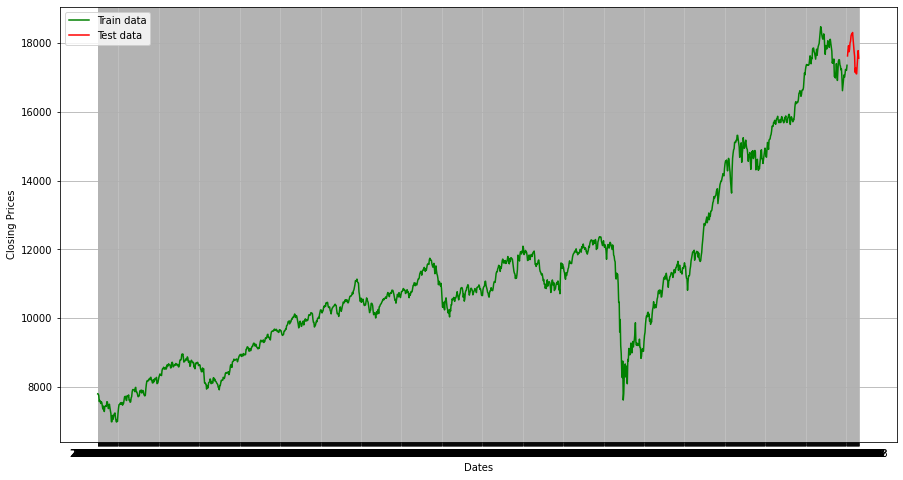

In [9]:
# plot 'Close' from training and test data
plt.figure(figsize=(15,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'red', label='Test data')
plt.legend()



In [10]:
# check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

  
print(calc_vif(train_data.loc[:,['Open', 'High', 'Low', 'Volume', 'Close']]))

  variables            VIF
0      Open   94512.018707
1      High  122896.960508
2       Low   86161.033740
3    Volume       5.019069
4     Close   98332.554475


In [11]:
# prepare features and labels data
x_train_df, y_train_df = train_data.loc[:,['Open', 'High', 'Low', 'Volume']].copy(), pd.DataFrame(train_data['Close'])
x_test_df, y_test_df = test_data.loc[:,['Open', 'High', 'Low', 'Volume']].copy(), pd.DataFrame(test_data['Close'])

In [12]:
x_train_df

,Open,High,Low,Volume
Date,,,,
2016-01-04,7924.549805,7937.549805,7781.100098,134700.0
2016-01-05,7828.399902,7831.200195,7763.250000,145200.0
2016-01-06,7788.049805,7800.950195,7721.200195,147100.0
2016-01-07,7673.350098,7674.950195,7556.600098,188900.0
2016-01-08,7611.649902,7634.100098,7581.049805,157400.0
...,...,...,...,...
2021-12-27,16937.750000,17112.050781,16833.199219,144800.0
2021-12-28,17177.599609,17250.250000,17161.150391,176000.0
2021-12-29,17220.099609,17285.949219,17176.650391,161700.0


In [13]:
# scale values b/w 0 and 1
from sklearn.preprocessing import MinMaxScaler
def scaler_transform(x,y):
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    x_train_df = pd.DataFrame(data = x_scaled, index = x.index)

    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y)
    y_train_df = pd.DataFrame(data = y_scaled)
    return x_train_df, y_train_df

x_train_df, y_train_df = scaler_transform(x_train_df, y_train_df)
x_test_df, y_test_df = scaler_transform(x_test_df, y_test_df)

In [14]:
x_train_df

,0,1,2,3
Date,,,,
2016-01-04,0.077807,0.078075,0.082215,0.074379
2016-01-05,0.069503,0.068884,0.080679,0.080177
2016-01-06,0.066018,0.066269,0.077060,0.081226
2016-01-07,0.056112,0.055379,0.062894,0.104307
2016-01-08,0.050783,0.051848,0.064998,0.086913
...,...,...,...,...
2021-12-27,0.856236,0.871014,0.861259,0.079956
2021-12-28,0.876951,0.882959,0.889483,0.097184
2021-12-29,0.880621,0.886044,0.890817,0.089288


In [15]:
# time series split to n
from sklearn.model_selection import TimeSeriesSplit
n_splits = 15
ts = TimeSeriesSplit(n_splits)

# training data and validation data split
for train_index, val_index in ts.split(x_train_df):
    x_train_s, x_val_s = x_train_df[:len(train_index)], x_train_df[len(train_index):(len(train_index)+len(val_index))]
    y_train, y_val = y_train_df[:len(train_index)].values.ravel(), y_train_df[len(train_index):(len(train_index)+len(val_index))].values.ravel()

In [16]:
# Reshape data dimension
x_train_np = np.array(x_train_s)
x_val_np = np.array(x_val_s)
x_test_np = np.array(x_test_df) 

x_train = x_train_np.reshape(x_train_np.shape[0], 1, x_train_np.shape[1])
x_val = x_val_np.reshape(x_val_np.shape[0], 1, x_val_np.shape[1])
x_test = x_test_np.reshape(x_test_np.shape[0], 1, x_test_np.shape[1])

x_train.shape, x_val.shape

((1389, 1, 4), (92, 1, 4))

## LSTM Model

In [17]:
from keras.layers import LSTM, Dense, Dropout, GaussianNoise
from keras.models import Input, Model

2022-02-10 19:58:52.875196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 19:58:52.875222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
# Using fuctional api as it can support complex architectures 
# that is not possible in Sequencial api

x_input = Input(shape=(1, x_train.shape[2]))
x = LSTM(96, activation='relu', return_sequences=False)(x_input)
x = GaussianNoise(0.05)(x) # introduce slight noise
x = Dropout(0.2)(x) # to avoid overfit
x_out = Dense(1)(x)

lstm_nse_1 = Model(x_input,x_out)
lstm_nse_1.compile(loss='mse', optimizer='adam')
lstm_nse_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 96)                38784     
_________________________________________________________________
gaussian_noise (GaussianNois (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 38,881
Trainable params: 38,881
Non-trainable params: 0
_________________________________________________________________


2022-02-10 19:58:54.290472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-10 19:58:54.290508: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-10 19:58:54.290532: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dn): /proc/driver/nvidia/version does not exist
2022-02-10 19:58:54.290827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
history = lstm_nse_1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=8, verbose=1, shuffle=False)

2022-02-10 19:58:54.686787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-10 19:58:54.703456: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3693175000 Hz


Epoch 1/50
174/174 [==============================] - 20s 7ms/step - loss: 0.0111 - val_loss: 3.9883e-04
Epoch 2/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0011
Epoch 3/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0019
Epoch 4/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 1.8858e-04
Epoch 5/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 1.7919e-04
Epoch 6/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 2.0904e-04
Epoch 7/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 4.4878e-04
Epoch 8/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/50
174/174 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/50
174/174 [==============================] - 0s 2ms/step - loss: 0.00

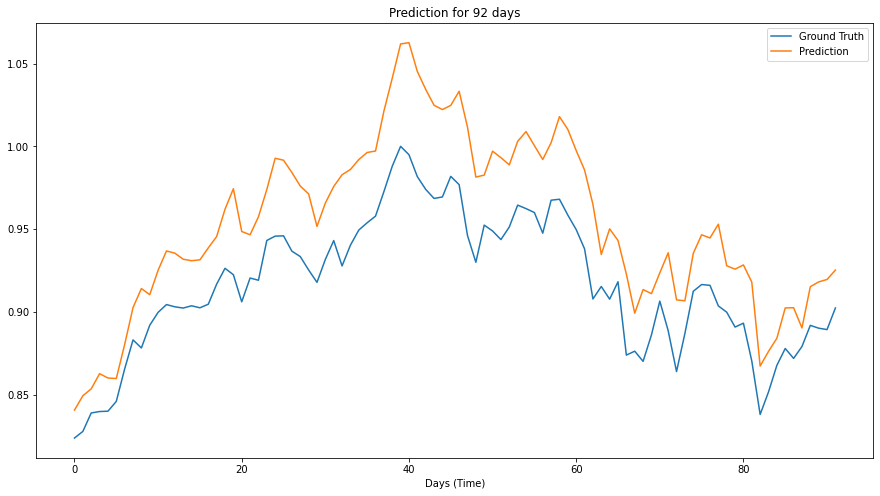

In [20]:
# Plot for validation data
y_pred= lstm_nse_1.predict(x_val)

plt.figure(figsize=(15,8))
plt.plot(y_val, label = 'Ground Truth')
plt.plot(y_pred, label = 'Prediction')
plt.title(f"Prediction for {len(y_pred)} days")
plt.xlabel('Days (Time)')
plt.legend()
plt.show()

## Test data validation
evaluating LSTM model on unseen data

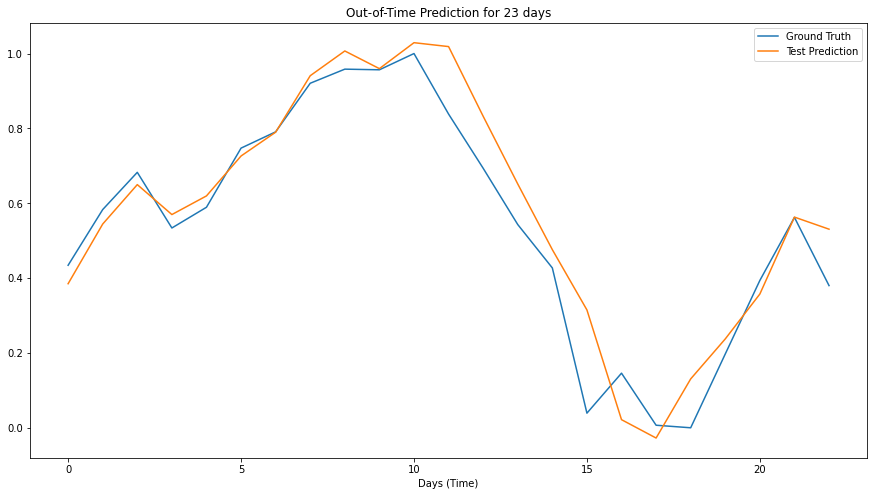

In [21]:
test_pred = lstm_nse_1.predict(x_test)

plt.figure(figsize=(15,8))
plt.plot(y_test_df, label = 'Ground Truth')
plt.plot(test_pred, label = 'Test Prediction')
plt.title(f"Out-of-Time Prediction for {len(y_test_df)} days")
plt.xlabel('Days (Time)')
plt.legend()
plt.show()

In [22]:
# Choosing Mean Squared Error(MSE) and Root Mean Square Error(RMSE) as evaluation metrics
from sklearn.metrics import mean_squared_error
import math
l_mse = mean_squared_error(y_test_df, test_pred)
l_rmse = math.sqrt(mean_squared_error(y_test_df, test_pred))

print('MSE: '+str(l_mse))
print('RMSE: '+str(l_rmse))

MSE: 0.009243912328993735
RMSE: 0.09614526680494331


## ARIMA model

In [23]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [24]:
# Training Auto Arima to get p, q and d for ARIMA
arima_model = auto_arima(y_train_df, exogenous=x_train_df, trace=True, error_action="ignore", suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-12045.911, Time=2.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-12822.480, Time=0.89 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-12831.886, Time=0.97 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-12829.446, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12208.854, Time=0.59 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-12809.386, Time=1.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10770.141, Time=2.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-11720.721, Time=2.41 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12263.856, Time=0.53 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 12.835 seconds


## Test data validation
evaluating Auto ARIMA model on unseen data

/home/ngx/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


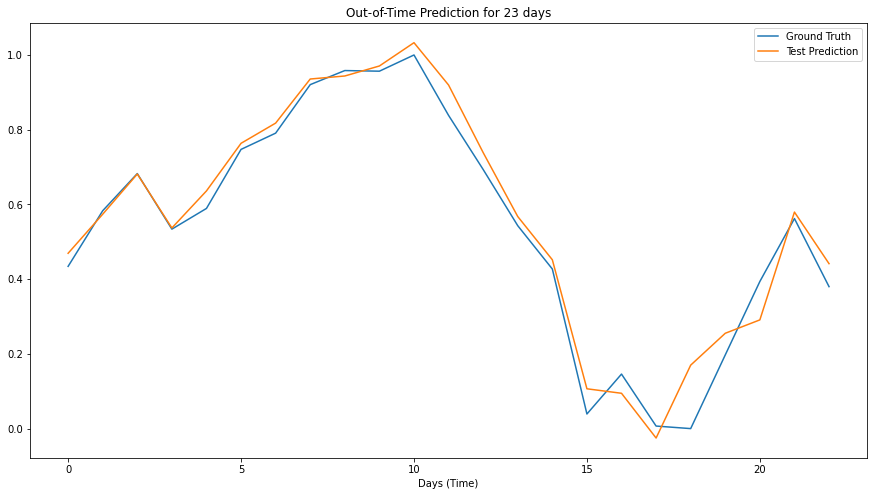

In [25]:
forecast_pred = arima_model.predict(n_periods=len(x_test_df), exogenous=x_test_df)

plt.figure(figsize=(15,8))
plt.plot(y_test_df, label = 'Ground Truth')
plt.plot(forecast_pred, label = 'Test Prediction')
plt.title(f"Out-of-Time Prediction for {len(y_test_df)} days")
plt.xlabel('Days (Time)')
plt.legend()
plt.show()

In [26]:
a_mse = mean_squared_error(y_test_df, forecast_pred)
a_rmse = math.sqrt(mean_squared_error(y_test_df, forecast_pred))

print('MSE: '+str(a_mse))
print('RMSE: '+str(a_rmse))

MSE: 0.0030932269468188027
RMSE: 0.05561678655602823


In [27]:
# p=1, q=0 and d=0 from Auto ARIMA
model = ARIMA(y_train_df, order=(1,0,0))
future = model.fit()

# Forecast with no additional features
days = 23
fc = future.forecast(days)

/home/ngx/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


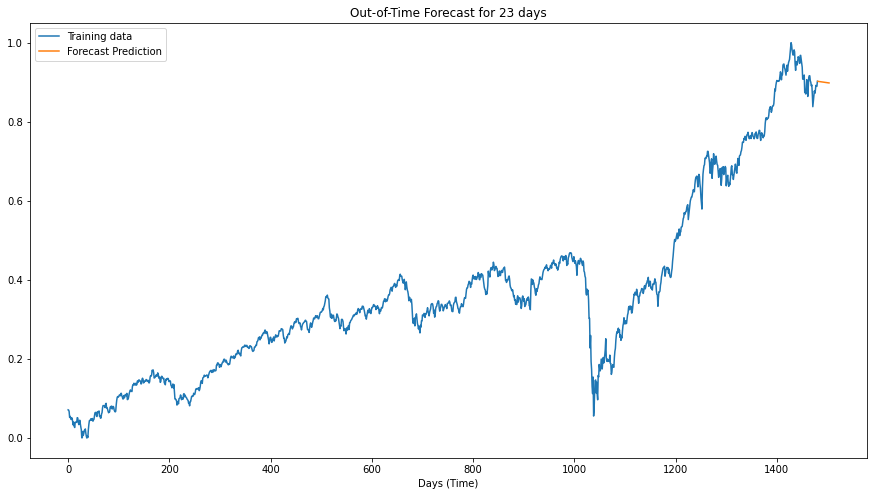

In [28]:
plt.figure(figsize=(15,8))
plt.plot(y_train_df, label = 'Training data')
plt.plot(fc, label = 'Forecast Prediction')
plt.title(f"Out-of-Time Forecast for {len(y_test_df)} days")
plt.xlabel('Days (Time)')
plt.legend()
plt.show()

## Results

In [29]:
print("\tMSE\tRMSE")
print(f"LSTM\t{round(l_mse,4)}\t{round(l_rmse,4)}")
print(f"ARIMA\t{round(a_mse,4)}\t{round(a_rmse,4)}")

	MSE	RMSE
LSTM	0.0092	0.0961
ARIMA	0.0031	0.0556


As the results shows ARIMA model performs better for this use case.